In [1]:
# imports for the HW
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import torch
import torchvision
import random

In [2]:
n_epochs = 5 # the number of epochs to run.
batch_size_train = 64 # the number of images to load in each train iteration.
batch_size_test = 1000 # the number of images to load in each test iteration.
learning_rate = 0.0001 # the gradient decent step size.
momentum = 0.9 # our optimizer momentum coefficient
# seeding the random process in our model so we could reproduce our results
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


Batch shape: torch.Size([64, 1, 28, 28])


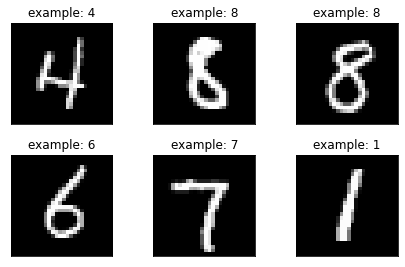

In [3]:
# 3.a - Loading MNIST dataset

# pre-processing transformation to the data
transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# loading the train data
train_dataset=torchvision.datasets.MNIST(root='my_data',
                                         train=True,
                                         download=True,
                                         transform=transformation)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)
# printing the batch shape
examples = enumerate(train_loader)
batch_idx, (example_data, example_labels) = next(examples)
print(f"Batch shape: {example_data.shape}")
# printing a few examples
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"example: {example_labels[i]}")
    plt.xticks([])
    plt.yticks([])



In [4]:
# Loading the test data

test_dataset = torchvision.datasets.MNIST(root='my_data',
                                         train=False,
                                         download=True,
                                         transform=transformation)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size_test,
                                           shuffle=True)

# printing the batch shape
examples = enumerate(test_loader)
batch_idx, (example_data, example_labels) = next(examples)
print(f"Batch shape: {example_data.shape}")


Batch shape: torch.Size([1000, 1, 28, 28])


In [5]:
# 3.b - Building the NN
# Our Network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
         super(Net, self).__init__()
         self.fc1 = nn.Linear(28*28, 10)
         self.fc2 = nn.Linear(10, 10)
         self.batch_norm = nn.BatchNorm1d(10)
         self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
     x = torch.flatten(x, 1)
     x = self.fc1(x)
     x = F.relu(x)
     x = self.softmax(x)
     return x

net = Net()


import torch.optim as optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)


In [6]:
# 3.c - Training the NN

import time
def train(model, train_loader, optimizer, loss_function, epoch):
    """
    Train the model for one epoch.
    :param model: the model we are training.
    :param train_loader: the dataloader which our model iterats over in one epoch.
    :optimizer: the kind of optimzer we are using.
    :loss_function: the loss function we are using.
    :epoch: the number of the epoch we are iterating over.

    :return:
        epoch_time: the time it took to train an epoch.
        loss_value: the total loss of the epoch
    """
    start = time.time()

    model.train()
    for batch_indx, data in enumerate(train_loader, 0):

        total_loss = 0.0

        inputs, labels = data

        # initiate the gradient parameters
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # calculating the loss
        loss = loss_function(outputs, labels)

        # backward pass
        loss.backward()

        # preforming the gradient descent step
        optimizer.step()

        # calculating total loss
        total_loss += loss.item()

    print(f'epoch_number: {epoch + 1}, loss: {total_loss}')
    end = time.time()
    epoch_time = end - start
    print(f"epoch {epoch+1} time to train {epoch_time} seconds.")
    return epoch_time, total_loss

def test(model, test_loader, loss_function):
    """
    Test our model accuracy on our test dataset.
    :param model: the model we are training.
    :param test_loader: the dataloader which our model iterats over in one epoch.
    :param loss_function: the loss_function our model uses.

    :return:
    test_acc: the accuracy of our model on the test dataset.
    """

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            output = model(data)
            test_loss += loss_function(output, label).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)

            correct += pred.eq(label.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100*(correct / len(test_loader.dataset))

In [7]:
# train the model for 5 epochs
time_train=[]
train_loss=[]
test_accuracy=[]

for i in range(n_epochs):
    time_train_epoch, train_loss_epoch = train(net, train_loader, optimizer, loss_function, i)
    test_accuracy_epoch=test(net, test_loader, loss_function)
    time_train.append(time_train_epoch)
    train_loss.append(train_loss_epoch)
    test_accuracy.append(test_accuracy_epoch)


# print the average train time
time_train_avg = np.mean(time_train)
print('the Average train time is: {}' .format(time_train_avg))


epoch_number: 1, loss: 2.2997255325317383
epoch 1 time to train 4.191072702407837 seconds.

Test set: Average loss: 0.0023, Accuracy: 1725/10000 (17%)

epoch_number: 2, loss: 2.2904891967773438
epoch 2 time to train 4.130792856216431 seconds.

Test set: Average loss: 0.0023, Accuracy: 2364/10000 (24%)

epoch_number: 3, loss: 2.282163381576538
epoch 3 time to train 4.226788759231567 seconds.

Test set: Average loss: 0.0023, Accuracy: 2679/10000 (27%)

epoch_number: 4, loss: 2.269253969192505
epoch 4 time to train 4.115955114364624 seconds.

Test set: Average loss: 0.0023, Accuracy: 2879/10000 (29%)

epoch_number: 5, loss: 2.2431328296661377
epoch 5 time to train 4.1203320026397705 seconds.

Test set: Average loss: 0.0023, Accuracy: 3093/10000 (31%)

the Average train time is: 4.156988286972046


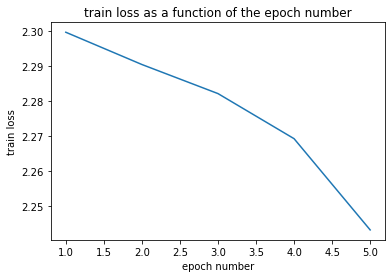

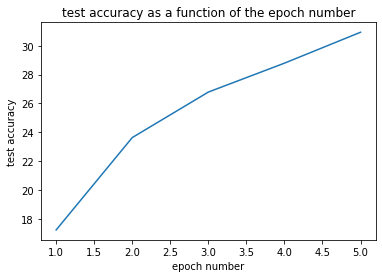

In [8]:
# plot graphs of the train loss as a function of the epoch number
plt.plot(list(range(1,6)), train_loss)
plt.title('train loss as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('train loss')
plt.show()

# plot graphs of the test accuracy as a function of the epoch number
plt.plot(list(range(1,6)), test_accuracy)
plt.title('test accuracy as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('test accuracy')
plt.show()

In [9]:
# 3.d - Improving our NN


class Net2(nn.Module):
    def __init__(self):
         super(Net2, self).__init__()
         self.fc1 = nn.Linear(28*28, 10)
         self.fc2 = nn.Linear(10, 10)
         self.batch_norm = nn.BatchNorm1d(10)
         self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
     x = torch.flatten(x, 1)
     x = self.fc1(x)
     x = F.relu(x)
     x = self.fc2(x)
     x = F.relu(x)
     x = self.batch_norm(x)
     x = self.softmax(x)
    
     return x



epoch_number: 1, loss: 2.1546528339385986
epoch 1 time to train 4.717554092407227 seconds.

Test set: Average loss: 0.0021, Accuracy: 4007/10000 (40%)

epoch_number: 2, loss: 2.1359965801239014
epoch 2 time to train 4.533572435379028 seconds.

Test set: Average loss: 0.0021, Accuracy: 4684/10000 (47%)

epoch_number: 3, loss: 2.0679640769958496
epoch 3 time to train 5.344845771789551 seconds.

Test set: Average loss: 0.0021, Accuracy: 4898/10000 (49%)

epoch_number: 4, loss: 2.1094391345977783
epoch 4 time to train 4.55014967918396 seconds.

Test set: Average loss: 0.0021, Accuracy: 5007/10000 (50%)

epoch_number: 5, loss: 2.037403106689453
epoch 5 time to train 5.264391183853149 seconds.

Test set: Average loss: 0.0020, Accuracy: 5041/10000 (50%)

the Average train time is: 4.882102632522583


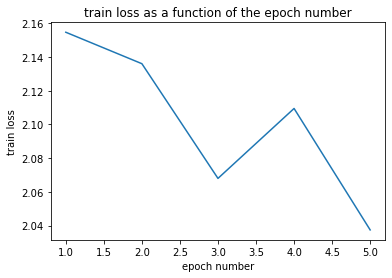

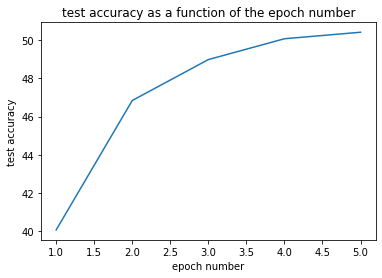

In [10]:
# improved net with the original hyper-parameter 

net2 = Net2()

optimizer = optim.SGD(net2.parameters(), lr=learning_rate, momentum=momentum)
  
    
time_train=[]
train_loss=[]
test_accuracy=[]

for i in range(n_epochs):
    time_train_epoch, train_loss_epoch = train(net2, train_loader, optimizer, loss_function, i)
    test_accuracy_epoch=test(net2, test_loader, loss_function)
    time_train.append(time_train_epoch)
    train_loss.append(train_loss_epoch)
    test_accuracy.append(test_accuracy_epoch)


# print the average train time
time_train_avg = np.mean(time_train)
print('the Average train time is: {}' .format(time_train_avg))

# plot graphs of the train loss as a function of the epoch number
plt.plot(list(range(1,6)), train_loss)
plt.title('train loss as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('train loss')
plt.show()

# plot graphs of the test accuracy as a function of the epoch number
plt.plot(list(range(1,6)), test_accuracy)
plt.title('test accuracy as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('test accuracy')
plt.show()


epoch_number: 1, loss: 2.1850643157958984
epoch 1 time to train 5.545429706573486 seconds.

Test set: Average loss: 0.0022, Accuracy: 4110/10000 (41%)

epoch_number: 2, loss: 2.0993576049804688
epoch 2 time to train 5.61016845703125 seconds.

Test set: Average loss: 0.0021, Accuracy: 5117/10000 (51%)

epoch_number: 3, loss: 2.035435676574707
epoch 3 time to train 5.450507879257202 seconds.

Test set: Average loss: 0.0020, Accuracy: 5581/10000 (56%)

epoch_number: 4, loss: 2.007312536239624
epoch 4 time to train 5.494472026824951 seconds.

Test set: Average loss: 0.0020, Accuracy: 5780/10000 (58%)

epoch_number: 5, loss: 2.0270087718963623
epoch 5 time to train 5.40773606300354 seconds.

Test set: Average loss: 0.0020, Accuracy: 5878/10000 (59%)

epoch_number: 6, loss: 1.9163813591003418
epoch 6 time to train 4.573815822601318 seconds.

Test set: Average loss: 0.0020, Accuracy: 5973/10000 (60%)

epoch_number: 7, loss: 2.0007243156433105
epoch 7 time to train 5.590322017669678 seconds.



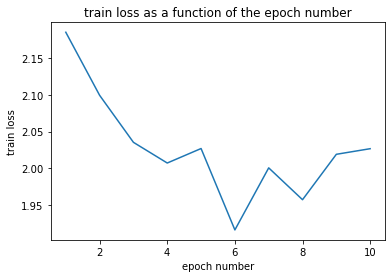

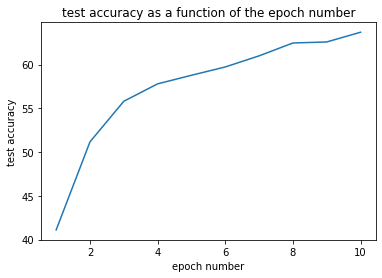

In [11]:
# for 10 epochs
net3 = Net2()
optimizer = optim.SGD(net3.parameters(), lr=learning_rate, momentum=momentum)

# train the model for 10 epochs
time_train=[]
train_loss=[]
test_accuracy=[]

for i in range(2*n_epochs):
    time_train_epoch, train_loss_epoch = train(net3, train_loader, optimizer, loss_function, i)
    test_accuracy_epoch=test(net3, test_loader, loss_function)
    time_train.append(time_train_epoch)
    train_loss.append(train_loss_epoch)
    test_accuracy.append(test_accuracy_epoch)


# print the average train time
time_train_avg = np.mean(time_train)
print('the Average train time is: {}' .format(time_train_avg))

# plot graphs of the train loss as a function of the epoch number
plt.plot(list(range(1,11)), train_loss)
plt.title('train loss as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('train loss')
plt.show()

# plot graphs of the test accuracy as a function of the epoch number
plt.plot(list(range(1,11)), test_accuracy)
plt.title('test accuracy as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('test accuracy')
plt.show()

epoch_number: 1, loss: 2.13486909866333
epoch 1 time to train 5.294306039810181 seconds.

Test set: Average loss: 0.0021, Accuracy: 4650/10000 (46%)

epoch_number: 2, loss: 2.0680878162384033
epoch 2 time to train 4.318974018096924 seconds.

Test set: Average loss: 0.0021, Accuracy: 5220/10000 (52%)

epoch_number: 3, loss: 2.068333387374878
epoch 3 time to train 4.465489387512207 seconds.

Test set: Average loss: 0.0020, Accuracy: 5410/10000 (54%)

epoch_number: 4, loss: 2.0417497158050537
epoch 4 time to train 4.544114589691162 seconds.

Test set: Average loss: 0.0020, Accuracy: 5521/10000 (55%)

epoch_number: 5, loss: 2.0438053607940674
epoch 5 time to train 4.527789354324341 seconds.

Test set: Average loss: 0.0020, Accuracy: 5584/10000 (56%)

the Average train time is: 4.6301346778869625


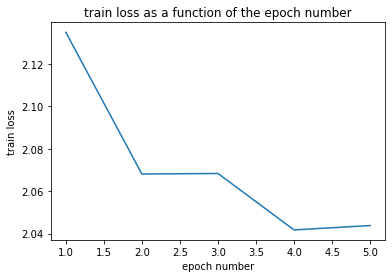

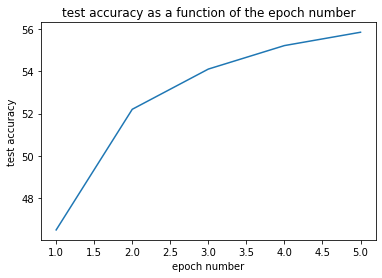

In [12]:
# for double train batch size

net4 = Net2()

batch_size_train = 2*batch_size_train

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)

optimizer = optim.SGD(net4.parameters(), lr=learning_rate, momentum=momentum)

time_train=[]
train_loss=[]
test_accuracy=[]

for i in range(n_epochs):
    time_train_epoch, train_loss_epoch = train(net4, train_loader, optimizer, loss_function, i)
    test_accuracy_epoch=test(net4, test_loader, loss_function)
    time_train.append(time_train_epoch)
    train_loss.append(train_loss_epoch)
    test_accuracy.append(test_accuracy_epoch)


# print the average train time
time_train_avg = np.mean(time_train)
print('the Average train time is: {}' .format(time_train_avg))



# plot graphs of the train loss as a function of the epoch number
plt.plot(list(range(1,6)), train_loss)
plt.title('train loss as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('train loss')
plt.show()

# plot graphs of the test accuracy as a function of the epoch number
plt.plot(list(range(1,6)), test_accuracy)
plt.title('test accuracy as a function of the epoch number')
plt.xlabel('epoch number')
plt.ylabel('test accuracy')
plt.show()

